In [29]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.layers import LSTM
%matplotlib inline

In [30]:
df = pd.read_csv("stock.csv")
df = df.dropna()
df.head()

,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
0,2018-09-28,234.05,235.95,230.20,233.50,233.75,3069914,7162.35
1,2018-09-27,234.55,236.80,231.10,233.80,233.25,5082859,11859.95
2,2018-09-26,240.00,240.00,232.50,235.00,234.25,2240909,5248.60
3,2018-09-25,233.30,236.75,232.00,236.25,236.10,2349368,5503.90
4,2018-09-24,233.55,239.20,230.75,234.00,233.30,3423509,7999.55


In [31]:
df.tail()


,Date,Open,High,Low,Last,Close,Total Trade Quantity,Turnover (Lacs)
2030,2010-07-27,117.6,119.50,112.00,118.80,118.65,586100,694.98
2031,2010-07-26,120.1,121.00,117.10,117.10,117.60,658440,780.01
2032,2010-07-23,121.8,121.95,120.25,120.35,120.65,281312,340.31
2033,2010-07-22,120.3,122.00,120.25,120.75,120.90,293312,355.17
2034,2010-07-21,122.1,123.00,121.05,121.10,121.55,658666,803.56


In [32]:
df_close = df['Close']

In [33]:
df_close.shape

(2035,)

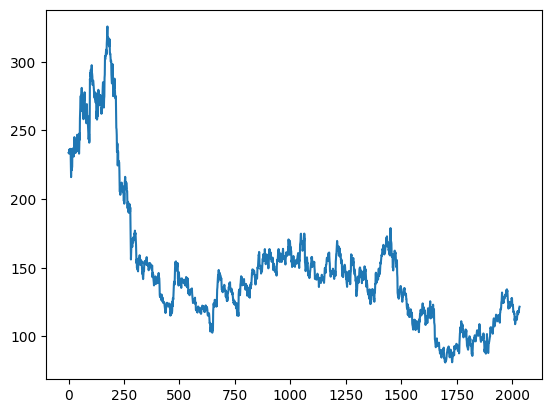

In [34]:
plt.plot(df_close)


In [35]:
scaler = MinMaxScaler(feature_range = (0,1))
df_close = scaler.fit_transform(np.array(df_close).reshape(-1,1))

In [36]:
df_close.shape


(2035, 1)

In [37]:
df_close


array([[0.62418301],
       [0.62214052],
       [0.62622549],
       ...,
       [0.1621732 ],
       [0.16319444],
       [0.16584967]])

In [38]:
training_size = int(len(df_close) * 0.75)
test_size = len(df_close) - training_size
train_data, test_data = df_close[0:training_size,:], df_close[training_size:len(df_close),:1]

In [39]:
def create_dataset(dataset, time_step = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i+time_step, 0])
    return np.array(dataX), np.array(dataY)

In [40]:
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [41]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [42]:
#Create the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 25, batch_size = 64, verbose = 1)

Epoch 1/25
23/23 [==============================] - 27s 483ms/step - loss: 0.0294 - val_loss: 0.0075
Epoch 2/25
23/23 [==============================] - 10s 458ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 3/25
23/23 [==============================] - 10s 458ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 4/25
23/23 [==============================] - 10s 458ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/25
23/23 [==============================] - 9s 395ms/step - loss: 0.0015 - val_loss: 0.0018
Epoch 6/25
23/23 [==============================] - 10s 454ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/25
23/23 [==============================] - 10s 454ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 8/25
23/23 [==============================] - 10s 455ms/step - loss: 0.0011 - val_loss: 9.6101e-04
Epoch 9/25
23/23 [==============================] - 12s 513ms/step - loss: 0.0011 - val_loss: 9.4199e-04
Epoch 10/25
23/23 [==============================] - 9s 396ms/step - loss: 0.0010 - 

In [44]:
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

In [45]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [46]:
math.sqrt(mean_squared_error(y_train, train_predict))

79.0152370885379

In [47]:
math.sqrt(mean_squared_error(y_test, test_predict))

80.35310671993041

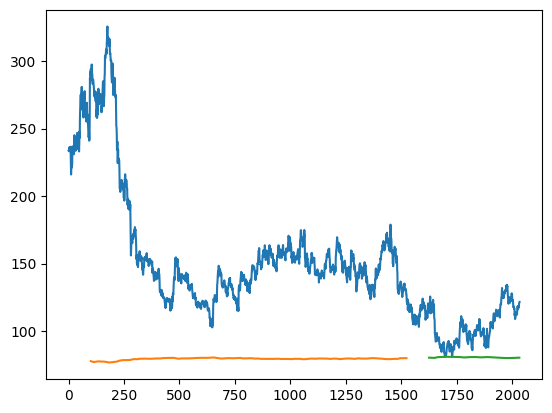

In [48]:
#Plotting

#Shift train prediction for plotting
look_back = 100
trainPredictPlot = np.empty_like(df_close)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, :] = train_predict

#Shift test prediction for plotting
testPredictPlot = np.empty_like(df_close)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back * 2)+1:len(df_close) - 1, :] = test_predict

#Plot baseline and predictions
plt.plot(scaler.inverse_transform(df_close))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [49]:
len(test_data), x_test.shape

(509, (408, 100, 1))

In [50]:
x_input = test_data[207:].reshape(1,-1)
x_input.shape

(1, 302)

In [51]:
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

In [52]:
lst_output=[]
n_steps=100
nextNumberOfDays = 30
i=0

In [53]:
day_new = np.arange(1,101)
day_pred = np.arange(101,131)

In [54]:
df3 = df_close.tolist()
df3.extend(lst_output)

In [55]:
len(df_close)

2035